# Imports

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from matplotlib.lines import Line2D
from tqdm import tqdm
import json
import zipfile
import os
import datetime
from datetime import datetime
import random
import seaborn as sns

# Mounting google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Datasets

Extracting them

In [3]:
def unzip_file(zip_file, destination_folder):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)

unzip_file("/content/drive/MyDrive/Paper hussein/dataset-part-1.zip", './')
unzip_file('/content/companies.csv.zip', './')
unzip_file('/content/entities.csv.zip', './')
unzip_file('/content/tweets.csv.zip', './')
unzip_file('/content/users.csv.zip', './')

In [4]:
entities_df = pd.read_csv('./entities.csv')
companies_df = pd.read_csv('./companies.csv')
tweets_df = pd.read_csv('./tweets.csv')

# Overall statistics about the dataset

### Cashtag-cloud of most tweeted companies

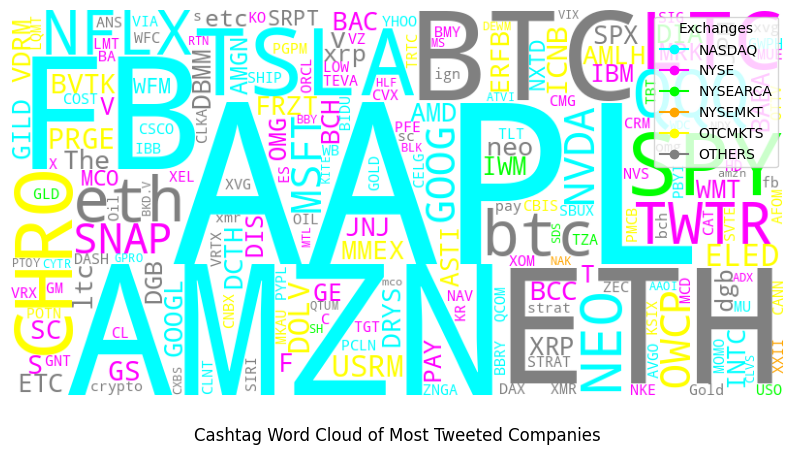

In [5]:
# Read entities dataset and filter rows for symbols
filtered_symbols_df = entities_df[entities_df['entity_type'] == 'symbol']

# Create a dictionary from the filtered symbol data
symbol_frequency_dict = filtered_symbols_df['text'].value_counts().to_dict()

# Create a word cloud based on symbol frequencies
symbol_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(symbol_frequency_dict)

# Define colors for different exchanges
exchange_colors = {
    "NASDAQ": 'cyan',
    "NYSE": 'magenta',
    "NYSEARCA": 'lime',
    "NYSEMKT": 'orange',
    "OTCMKTS": 'yellow',
    "OTHERS": 'gray'
}

# Match symbols to companies and assign colors
def assign_color(symbol):
    exchange = companies_df.loc[companies_df['ticker'] == symbol, 'exchange'].values
    if len(exchange) > 0:
        exchange = exchange[0]
        return exchange_colors.get(exchange, exchange_colors["OTHERS"])
    return exchange_colors["OTHERS"]

# Assign colors to symbols
symbol_colors = {symbol: assign_color(symbol) for symbol in symbol_frequency_dict.keys()}

# Plot the word cloud with assigned colors
plt.figure(figsize=(10, 6))
plt.imshow(symbol_wordcloud.recolor(color_func=lambda word, font_size, position, orientation, **kwargs: symbol_colors.get(word, 'red')))
plt.axis('off')

# Create a color legend for exchanges
legend_elements = [Line2D([0], [0], marker='o', color=color, label=exchange) for exchange, color in exchange_colors.items()]
plt.legend(handles=legend_elements, title='Exchanges', loc='upper right')

# Add a title below the plot
plt.text(0.5, -0.1, "Cashtag Word Cloud of Most Tweeted Companies", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.show()


### Mean tweet volume per hour

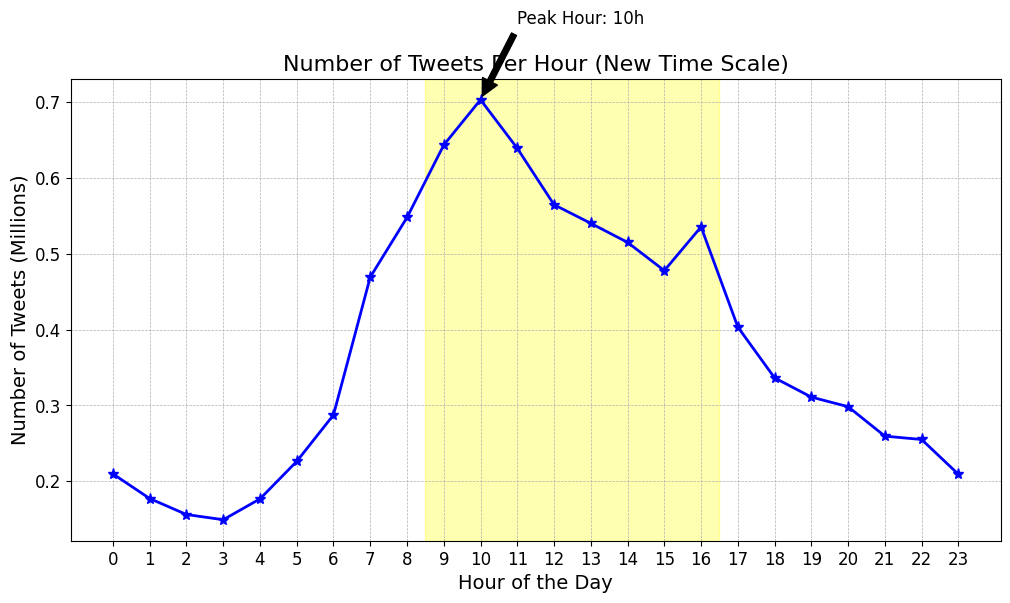

In [6]:
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], format='%a %b %d %H:%M:%S %z %Y')
tweets_df['created_at'] = tweets_df['created_at'].dt.tz_convert('US/Central')
tweets_df['created_at_adjusted'] = (tweets_df['created_at'].dt.hour + 1) % 24
tweets_per_hour = tweets_df['created_at_adjusted'].value_counts().sort_index()
peak_hour = tweets_per_hour.loc[9:16].idxmax()

# Normalize tweet counts for visualization
tweets_per_hour = tweets_per_hour / 1000000

# Create the plot
plt.figure(figsize=(12, 6))
tweets_per_hour.plot(kind='line', linestyle='-', marker='*', color='blue', linewidth=2, markersize=8)

# Highlight the peak hours with adjusted span for clarity
plt.axvspan(9 - 0.5, 16 + 0.5, color='yellow', alpha=0.3)

# Enhance plot aesthetics
plt.title('Number of Tweets Per Hour (New Time Scale)', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Number of Tweets (Millions)', fontsize=14)
plt.xticks(range(24), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optionally, annotate the peak hour
plt.annotate(f'Peak Hour: {peak_hour}h', xy=(peak_hour, tweets_per_hour[peak_hour]), xytext=(peak_hour+1, tweets_per_hour[peak_hour]+0.1),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

plt.show()

### Distribution of the number of cashtags per tweet

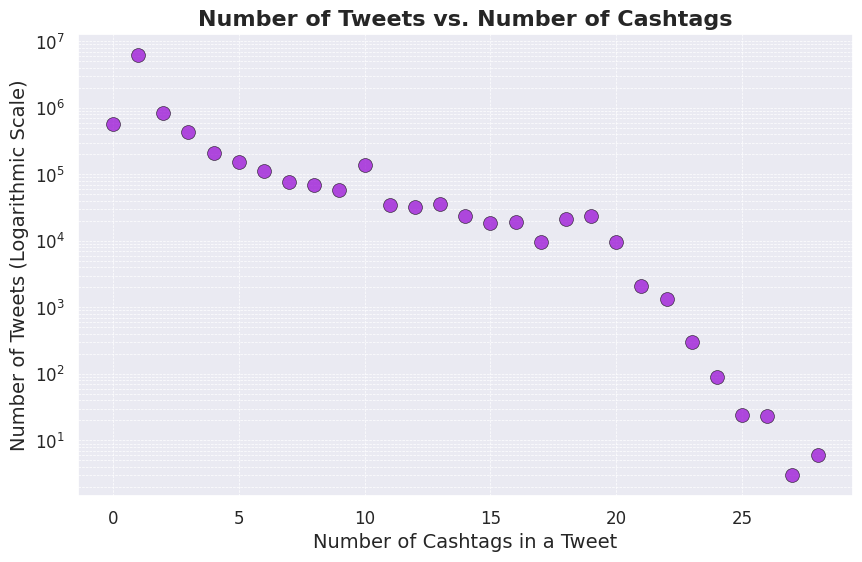

In [11]:
# Extract cashtags from the "text" column
tweets_df['cashtags'] = tweets_df['text'].str.findall(r'\$[A-Z]+')

# Count the number of cashtags in each tweet
tweets_df['cashtag_count'] = tweets_df['cashtags'].apply(lambda x: len(x))

# Limit the cashtag count to a maximum of 30
tweets_df['cashtag_count'] = tweets_df['cashtag_count'].clip(upper=30)

# Count the number of tweets for each cashtag count
tweets_per_cashtag_count = tweets_df['cashtag_count'].value_counts().sort_index()

# Set the style of seaborn for more visually appealing plots
sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))

# Use logarithmic scale for the y-axis
plt.yscale('log')

# Scatter plot with a more sophisticated color palette and marker style
scatter = plt.scatter(tweets_per_cashtag_count.index, tweets_per_cashtag_count.values,
                      color='darkviolet', alpha=0.7, edgecolor='black', linewidth=0.5, s=100,
                      marker='o')  # s controls the size of the markers

plt.title('Number of Tweets vs. Number of Cashtags', fontsize=16, fontweight='bold')
plt.xlabel('Number of Cashtags in a Tweet', fontsize=14)
plt.ylabel('Number of Tweets (Logarithmic Scale)', fontsize=14)

# Enhance tick marks for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding grid for better readability, seaborn style includes a grid by default
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

### Calculating time-series for all of Stocks

In [ ]:
data_folder = './'

# Filter symbol entities
symbol_entities_df = entities_df[entities_df['entity_type'] == 'symbol']

# Initialize variables
tweets_count_dict = {}

# Iterate over symbol entities dataset and update the dictionary
last_tweet_index = 0
current_date = None
current_hour = None

for index, entity_row in tqdm(symbol_entities_df.iterrows(), total=len(symbol_entities_df), desc="Processing Entities"):
    cashtag = entity_row['text']
    tweet_id = entity_row['tweet_id']

    # Find the corresponding tweet in the tweets dataset
    while last_tweet_index < len(tweets_df) and tweets_df.at[last_tweet_index, 'id'] < tweet_id:
        current_date = pd.to_datetime(tweets_df.at[last_tweet_index, 'created_at'], format='%a %b %d %H:%M:%S %z %Y').date()
        current_hour = pd.to_datetime(tweets_df.at[last_tweet_index, 'created_at'], format='%a %b %d %H:%M:%S %z %Y').hour
        last_tweet_index += 1

    # Check if tweet_id matches
    if last_tweet_index < len(tweets_df) and tweets_df.at[last_tweet_index, 'id'] == tweet_id:
        # Update the dictionary dynamically
        if cashtag not in tweets_count_dict:
            tweets_count_dict[cashtag] = {}

        if current_date not in tweets_count_dict[cashtag]:
            tweets_count_dict[cashtag][current_date] = {}

        if current_hour not in tweets_count_dict[cashtag][current_date]:
            tweets_count_dict[cashtag][current_date][current_hour] = 0

        tweets_count_dict[cashtag][current_date][current_hour] += 1

### Saving Time-Series File

In [ ]:
# Convert date objects to strings for JSON serialization
def convert_dates_to_str(d):
    if isinstance(d, datetime.date):
        return d.strftime('%Y-%m-%d')
    elif isinstance(d, dict):
        return {convert_dates_to_str(k): convert_dates_to_str(v) for k, v in d.items()}
    elif isinstance(d, (list, tuple)):
        return [convert_dates_to_str(item) for item in d]
    return d

# Convert date objects to strings in the dictionary
tweets_count_dict_str = convert_dates_to_str(tweets_count_dict)

# Save the dictionary to a file
save_path = os.path.join(data_folder, 'tweets_count.json')
with open(save_path, 'w') as file:
    json.dump(tweets_count_dict_str, file)

### Loading Time-Series File

In [9]:
# Load the dictionary from the file
file_path = './tweets_count.json'
with open(file_path, 'r') as file:
    loaded_dict_str = json.load(file)

# Create a new dictionary with datetime keys
tweets_count_dict = {}

# Function to convert date and hour strings to datetime objects
def convert_to_datetime(date_str, hour_str):
    if date_str.lower() == 'null':
        return None  # Handle null value as needed
    if hour_str.lower() == 'null':
        hour_str = '00'  # Use a default hour if needed
    date_time_str = f"{date_str} {hour_str}"
    return datetime.strptime(date_time_str, "%Y-%m-%d %H")


for cashtag, date_dict in loaded_dict_str.items():
    # Convert cashtag to uppercase
    cashtag_upper = cashtag.upper()

    if cashtag_upper not in tweets_count_dict:
        tweets_count_dict[cashtag_upper] = {}

    for date_str, hour_dict in date_dict.items():
        date_time = convert_to_datetime(date_str, "00")  # Use a default hour if needed
        if date_time is not None:
            if date_time not in tweets_count_dict[cashtag_upper]:
                tweets_count_dict[cashtag_upper][date_time] = {}
            for hour_str, count in hour_dict.items():
                hour_time = datetime.strptime(hour_str, "%H")
                if hour_time.hour not in tweets_count_dict[cashtag_upper][date_time]:
                    tweets_count_dict[cashtag_upper][date_time][hour_time.hour] = count
                else:
                    tweets_count_dict[cashtag_upper][date_time][hour_time.hour] += count

### Finding peak hours

In [13]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from collections import defaultdict

# Vectorized operations for counting cashtags and mapping to companies
companies_df['tweet_count'] = companies_df['ticker'].map(entities_df['text'].value_counts()).fillna(0)

# Identify top 20s using pandas nlargest and querying
top_20_tweeted = companies_df.nlargest(20, 'tweet_count')['ticker']
top_20_otcmkts = companies_df.query("exchange == 'OTCMKTS'").nlargest(20, 'tweet_count')['ticker']

# Sample 100 unique cashtags without replacement
random_100 = companies_df['ticker'].sample(100, replace=False)

# Combine and deduplicate cashtags
cashtags = pd.concat([top_20_tweeted, top_20_otcmkts, random_100]).drop_duplicates()

# Initialize a more efficient structure for average and peak hours tracking
average_tweets_per_hour = {}
peak_hours = defaultdict(lambda: defaultdict(set))

# Process cashtags with tqdm progress bar
for cashtag in tqdm(cashtags, desc='Processing cashtags'):
    if cashtag in tweets_count_dict:
        tweet_dates_counts = tweets_count_dict[cashtag]

        # Flatten counts and calculate total tweets and average
        all_tweet_counts = [count for daily_counts in tweet_dates_counts.values() for count in daily_counts.values()]
        total_tweets = sum(all_tweet_counts)
        average_tweets_per_hour[cashtag] = total_tweets / len(all_tweet_counts) if all_tweet_counts else 0

        # Define threshold for peak hours detection
        threshold = average_tweets_per_hour[cashtag] + 5 * np.std(all_tweet_counts, ddof=1)

        # Find peak hours
        for date, hours_counts in tweet_dates_counts.items():
            for hour, count in hours_counts.items():
                if count > threshold:
                    peak_hours[date][hour].add(cashtag)

print(peak_hours)

Processing cashtags:   0%|          | 0/134 [00:00<?, ?it/s]

defaultdict(<function <lambda> at 0x7c3c51138700>, {datetime.datetime(2017, 6, 5, 0, 0): defaultdict(<class 'set'>, {13: {'NVDA', 'PRGE', 'TSLA', 'AAPL', 'SPY', 'QQQ', 'SNAP', 'AMZN'}, 14: {'PRGE', 'AAPL', 'MSFT', 'NFLX', 'SNAP', 'AMZN'}, 16: {'TSLA', 'SNAP'}, 17: {'TSLA', 'PRGE', 'SNAP'}, 12: {'QQQ'}}), datetime.datetime(2017, 6, 17, 0, 0): defaultdict(<class 'set'>, {13: {'FB', 'AAPL', 'OWCP', 'VDRM', 'GOOG', 'ICNB', 'FRZT', 'CHRO', 'SNAP'}, 14: {'SNAP'}}), datetime.datetime(2017, 6, 18, 0, 0): defaultdict(<class 'set'>, {21: {'USRM', 'FB', 'AAPL', 'OWCP', 'VDRM', 'GOOG', 'ICNB', 'FRZT', 'CHRO', 'SNAP'}}), datetime.datetime(2017, 6, 27, 0, 0): defaultdict(<class 'set'>, {16: {'NVDA', 'AAPL', 'MSFT', 'SPY', 'GOOG'}, 17: {'NVDA', 'FB', 'AAPL', 'MSFT', 'SPY', 'GOOG', 'AMZN'}, 10: {'QQQ'}, 13: {'QQQ'}}), datetime.datetime(2017, 6, 28, 0, 0): defaultdict(<class 'set'>, {14: {'NVDA', 'FB', 'AAPL', 'MSFT', 'SPY', 'GOOG'}, 13: {'QQQ'}}), datetime.datetime(2017, 6, 30, 0, 0): defaultdict(<cla

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Stock time series, for 12 highly tweeted stocks

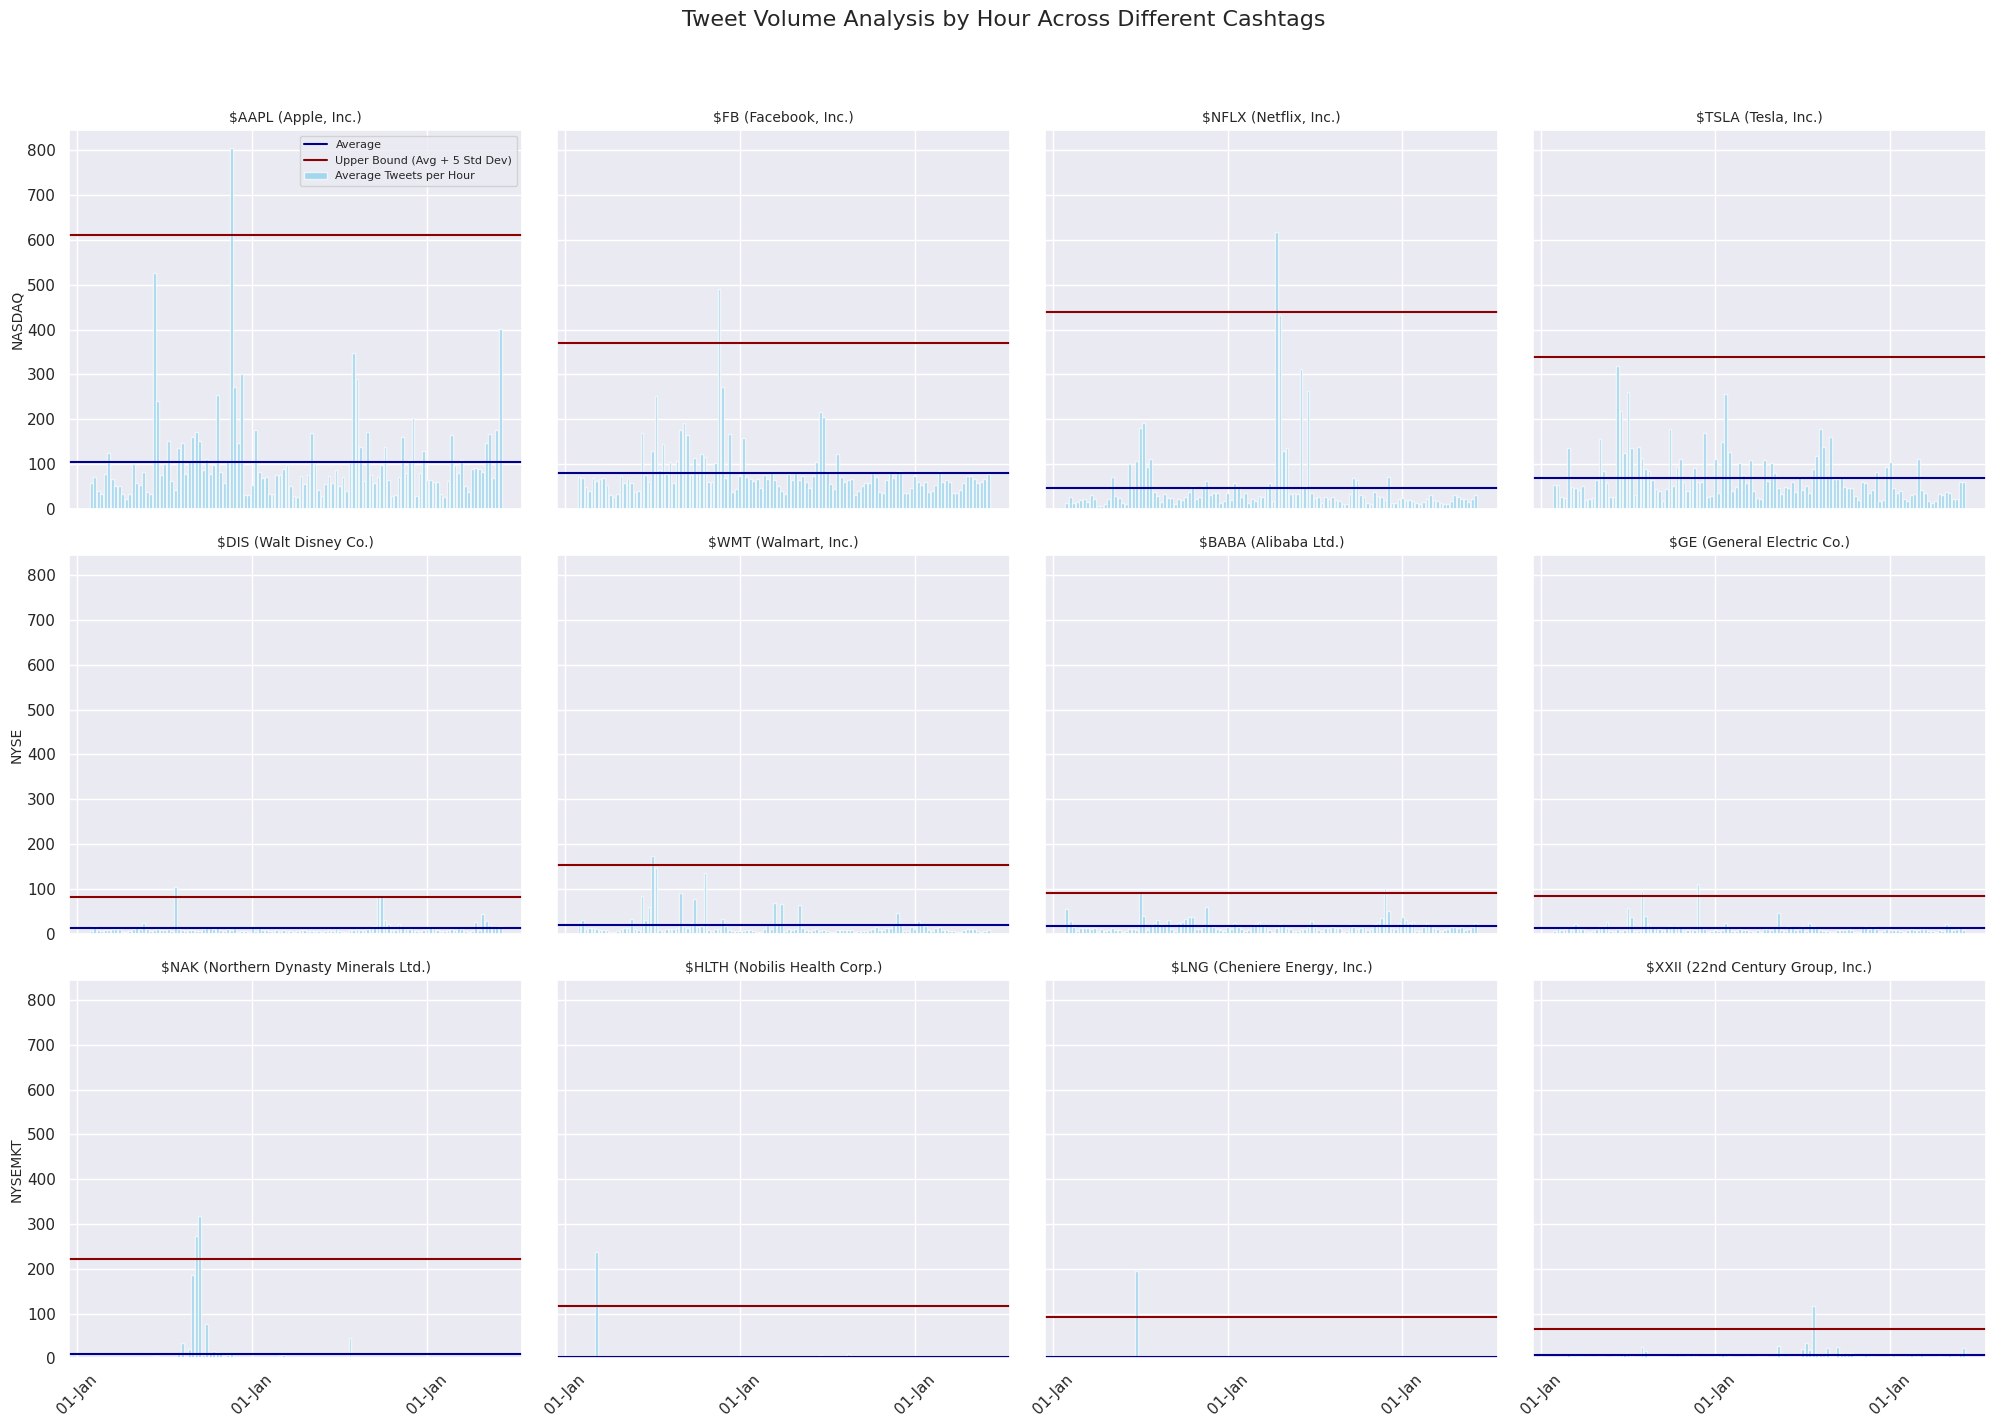

In [14]:
# Define cashtags, their corresponding exchanges, and descriptive plot titles
cashtags = ['AAPL', 'FB', 'NFLX', 'TSLA', 'DIS', 'WMT', 'BABA', 'GE', 'NAK', 'HLTH', 'LNG', 'XXII']
exchange_names = ['NASDAQ'] * 4 + ['NYSE'] * 4 + ['NYSEMKT'] * 4
plot_names = ['$AAPL (Apple, Inc.)', '$FB (Facebook, Inc.)', '$NFLX (Netflix, Inc.)', '$TSLA (Tesla, Inc.)',
              '$DIS (Walt Disney Co.)', '$WMT (Walmart, Inc.)', '$BABA (Alibaba Ltd.)', '$GE (General Electric Co.)',
              '$NAK (Northern Dynasty Minerals Ltd.)', '$HLTH (Nobilis Health Corp.)', '$LNG (Cheniere Energy, Inc.)', '$XXII (22nd Century Group, Inc.)']

# Set up a 3x4 grid for subplot visualization
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharex=True, sharey=True)
fig.suptitle('Tweet Volume Analysis by Hour Across Different Cashtags', fontsize=16)

# Process and plot data for each cashtag
for i, cashtag in enumerate(cashtags):
    ax = axes[i // 4, i % 4]  # Determine subplot position

    # Check if the cashtag is present in the dataset
    if cashtag in tweets_count_dict:
        dates, daily_means = zip(*[(date, np.mean(list(counts.values()))) for date, counts in tweets_count_dict[cashtag].items()])

        # Convert dates for plotting and adjust tick labels for clarity
        dates = pd.to_datetime(dates)  # Ensure dates are in pandas datetime format for ease of manipulation
        ax.bar(dates, daily_means, color='skyblue', alpha=0.7, label='Average Tweets per Hour')

        # Calculate and plot average line and upper bound for anomalies
        mean_line = np.mean(daily_means)
        upper_bound = mean_line + 5 * np.std(daily_means)
        ax.axhline(mean_line, color='darkblue', linestyle='-', label='Average')
        ax.axhline(upper_bound, color='darkred', linestyle='-', label='Upper Bound (Avg + 5 Std Dev)')

        # Customize x-axis to show date labels more clearly
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))  # Limit number of x-ticks
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).strftime('%d-%b')))

    # Set individual plot titles and adjust layout for readability
    ax.set_title(plot_names[i], fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    if i % 4 == 0:  # Annotate exchange name on the leftmost plots
        ax.annotate(exchange_names[i], xy=(-0.1, 0.5), xycoords='axes fraction', fontsize=10, rotation=90, va='center', ha='right')

    # Add legend to the first subplot only to avoid clutter
    if i == 0: ax.legend(loc='upper right', fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()


### Number of peaks detected, as a function of K

<ipython-input-20-a0e56acc2e50>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_cashtags = random.sample(loaded_dict_str.keys(), 1000)


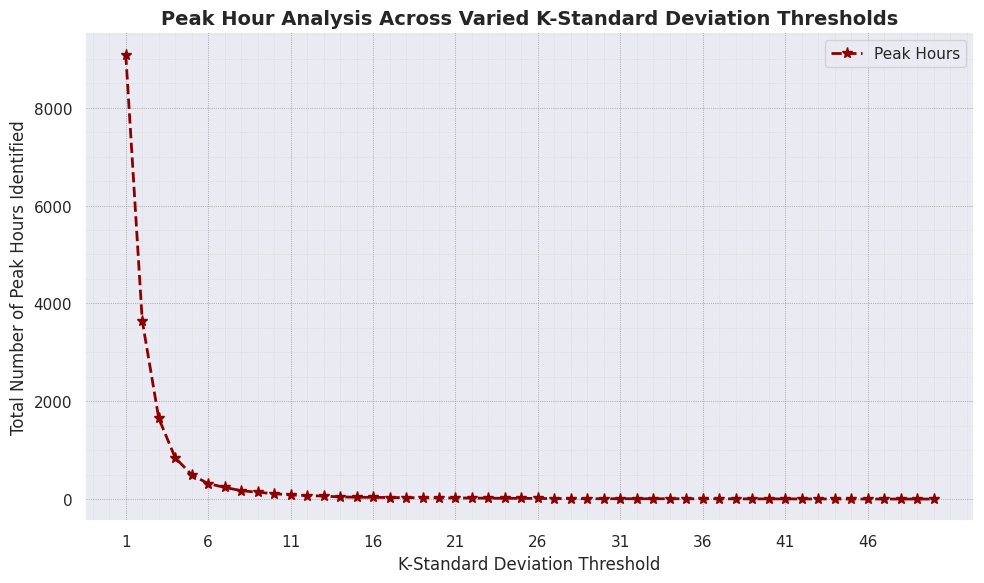

In [20]:
# Select 1000 cashtags randomly
random_cashtags = random.sample(loaded_dict_str.keys(), 1000)

# Initialize lists to store data for plotting
k_values = list(range(1, 51))
peak_counts = []

# Iterate over different values of K
for k in k_values:
    peak_count = 0  # Count of peak hours for the current K value

    # Iterate through each randomly selected cashtag
    for cashtag in random_cashtags:
        # Convert cashtag to uppercase
        cashtag_upper = cashtag.upper()

        # Initialize lists to store hourly tweet counts
        hourly_tweet_counts = []

        # Iterate through each date
        for date_str, hour_dict in loaded_dict_str[cashtag].items():
            date_time = convert_to_datetime(date_str, "00")  # Use a default hour if needed
            if date_time is not None:
                hourly_tweet_counts.extend(list(hour_dict.values()))

        # Calculate the average tweets per hour for the cashtag
        average_tweets_per_hour = np.mean(hourly_tweet_counts)

        # Count the number of peak hours (hours with tweets more than K standard deviations from average)
        for date_str, hour_dict in loaded_dict_str[cashtag].items():
            for count in hour_dict.values():
                if count > average_tweets_per_hour + k * np.std(hourly_tweet_counts):
                    peak_count += 1

    # Append the peak count for the current K value
    peak_counts.append(peak_count)

# Plot the number of peaks for each K value
plt.figure(figsize=(10, 6))
plt.plot(k_values, peak_counts, marker='*', linestyle='--', color='darkred', markersize=8, linewidth=2)

# Adding plot decorations for better visualization
plt.title('Peak Hour Analysis Across Varied K-Standard Deviation Thresholds', fontsize=14, fontweight='bold')
plt.xlabel('K-Standard Deviation Threshold', fontsize=12)
plt.ylabel('Total Number of Peak Hours Identified', fontsize=12)
plt.xticks(k_values[::5])
plt.grid(which='major', linestyle=':', linewidth='0.5', color='grey')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')

# Adding a legend for clarity
plt.legend(['Peak Hours'], loc='upper right')

plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()